# State budget comparisons

In this notebook, we compare the Swedish government's "spring budget" (with revisions of the current year's budget) with:

1. the government's original state budget for 2019, and
2. the current budget (by Moderaterna and Kristdemokraterna).


- Sources: [Regeringskansliet](https://www.regeringen.se/sveriges-regering/finansdepartementet/statens-budget/statens-budget-som-excel/), [Riksdagen (Statens budget 2019 Rambeslutet)](https://data.riksdagen.se/fil/4F97AE56-F063-441D-A1C3-1ADF5D6DC63A)
- Date: 2019-04-11

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from src.plot import ds_plot

%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', lambda x: '%.3f' % x)

if 'datastory' in plt.style.available:
    plt.style.use('datastory')

In [2]:
# From Regeringskansliet (see link above)
new_budget = pd.read_excel('../data/raw/budget/andringsbudget-2019.xlsx',
                           skiprows=3, skipfooter=1, dtype={'Utgifts-område': str})

# Cleaned version of a PDF table from Riksdagen (see link above)
old_budget = pd.read_csv('../data/raw/budget/budget-2019.csv',
                         thousands=' ', dtype={'Utgiftsområde': str})

In [3]:
old_budget.head()

,Utgiftsområde,Namn,Avvikelse från regeringen,Reservanternas förslag
0,01,Rikets styrelse,-308000,14593645
1,02,Samhällsekonomi och finansförvaltning,3500,17318966
2,03,"Skatt, tull och exekution",120000,11522533
3,04,Rättsväsendet,2041000,48383859
4,05,Internationell samverkan,0,2362277


In [4]:
new_budget.head(5)

,Unnamed: 0,Utgifts-område,Anslags-nummer,Unnamed: 3,Beslutad ram/anvisat anslag,Förändring av ram/anslag,Ny ram/
0,nan,NaN,NaN,NaN,nan,nan,Ny anslagsnivå
1,nan,1,,Rikets styrelse,14593645.000,149009.000,14742654
2,nan,,01:01:00,Kungliga hov- och slottsstaten,140685.000,4000.000,144685
3,nan,NaN,04:01:00,Regeringskansliet m.m.,7806618.000,86909.000,7893527
4,nan,,05:01:00,Länsstyrelserna m.m.,3016691.000,11000.000,3027691


## Clean and transform data

### Old budget

In [5]:
old_budget = old_budget.set_index('Utgiftsområde')

# Original values are in the unit thousand kronor
for col in ['Avvikelse från regeringen', 'Reservanternas förslag']:
    old_budget[col] = old_budget[col] * 1_000

### New budget

In [6]:
new_budget = new_budget.iloc[1:]
new_budget = new_budget.dropna(how='all', axis=1)

In [7]:
new_budget.columns = ['expenditure', 'allocation', 'label',
                      'budget_original', 'budget_changed', 'budget_new']

In [8]:
# Original values are in the unit thousand kronor
for col in ['budget_original', 'budget_changed', 'budget_new']:
    new_budget[col] = new_budget[col] * 1_000

In [9]:
# We are only interested in the top level expenditure posts
new_budget.expenditure = new_budget.expenditure.replace(' ', np.nan)
new_budget.allocation = new_budget.allocation.replace(' ', np.nan)
new_budget.expenditure = new_budget.expenditure.apply(lambda x: str(x).zfill(2))
new_budget = new_budget[new_budget.allocation.isnull()]
new_budget = new_budget.set_index('expenditure')
new_budget = new_budget.drop('allocation', axis=1)

### Merge documents

In [10]:
df = new_budget.merge(old_budget, left_index=True,
                      right_index=True, how='right')

In [11]:
# Clean up a bit
df.budget_new = df.budget_new.astype(float)
df.budget_original = df.budget_original.fillna(df['Reservanternas förslag'])
df = df.drop(['Reservanternas förslag'], axis=1)
df['s_prop'] = df.budget_original - df['Avvikelse från regeringen']
df = df.drop('Avvikelse från regeringen', axis=1)
df = df.drop('budget_changed', axis=1)
df.label = df.label.fillna(df.Namn)
df = df.drop('Namn', axis=1)
df.columns = ['expenditure', 'budget_m_kd', 'budget_gov_new', 'budget_gov_old']
df.budget_gov_new = df.budget_gov_new.fillna(df.budget_m_kd)

In [12]:
df.head()

,expenditure,budget_m_kd,budget_gov_new,budget_gov_old
Utgiftsområde,,,,
01,Rikets styrelse,14593645000.000,14742654000.000,14901645000.000
02,Samhällsekonomi och finansförvaltning,17318966000.000,17292729000.000,17315466000.000
03,"Skatt, tull och exekution",11522533000.000,11509475000.000,11402533000.000
04,Rättsväsendet,48383859000.000,49203359000.000,46342859000.000
05,Internationell samverkan,2362277000.000,2360277000.000,2362277000.000


### Add shortened name versions

In [13]:
short = pd.read_csv('../data/raw/budget/budget_shortnames_shorter.csv',
                    sep=';', dtype={'UO': str})
short.UO = short.UO.apply(lambda x: x.zfill(2))
short = short.drop('name', axis=1)
df = df.merge(short, left_index=True, right_on='UO')
df = df.drop('UO', axis=1)

In [14]:
df.head()

,expenditure,budget_m_kd,budget_gov_new,budget_gov_old,short_name
0,Rikets styrelse,14593645000.000,14742654000.000,14901645000.000,Politiskt styre
1,Samhällsekonomi och finansförvaltning,17318966000.000,17292729000.000,17315466000.000,Statens kostnader
2,"Skatt, tull och exekution",11522533000.000,11509475000.000,11402533000.000,Skatt & tull
3,Rättsväsendet,48383859000.000,49203359000.000,46342859000.000,Lag & rätt
4,Internationell samverkan,2362277000.000,2360277000.000,2362277000.000,Global samverkan


### Calculate changes

In [15]:
# Absolute change in kronor
df['diff'] = df.budget_gov_new - df.budget_gov_old

# Percentage change
df['diff_prc'] = df['diff'] / df.budget_gov_old * 100

## Plot

### Horizontal percentage change bars

Plot the percentage change of the "spring budget" vs the current budget.

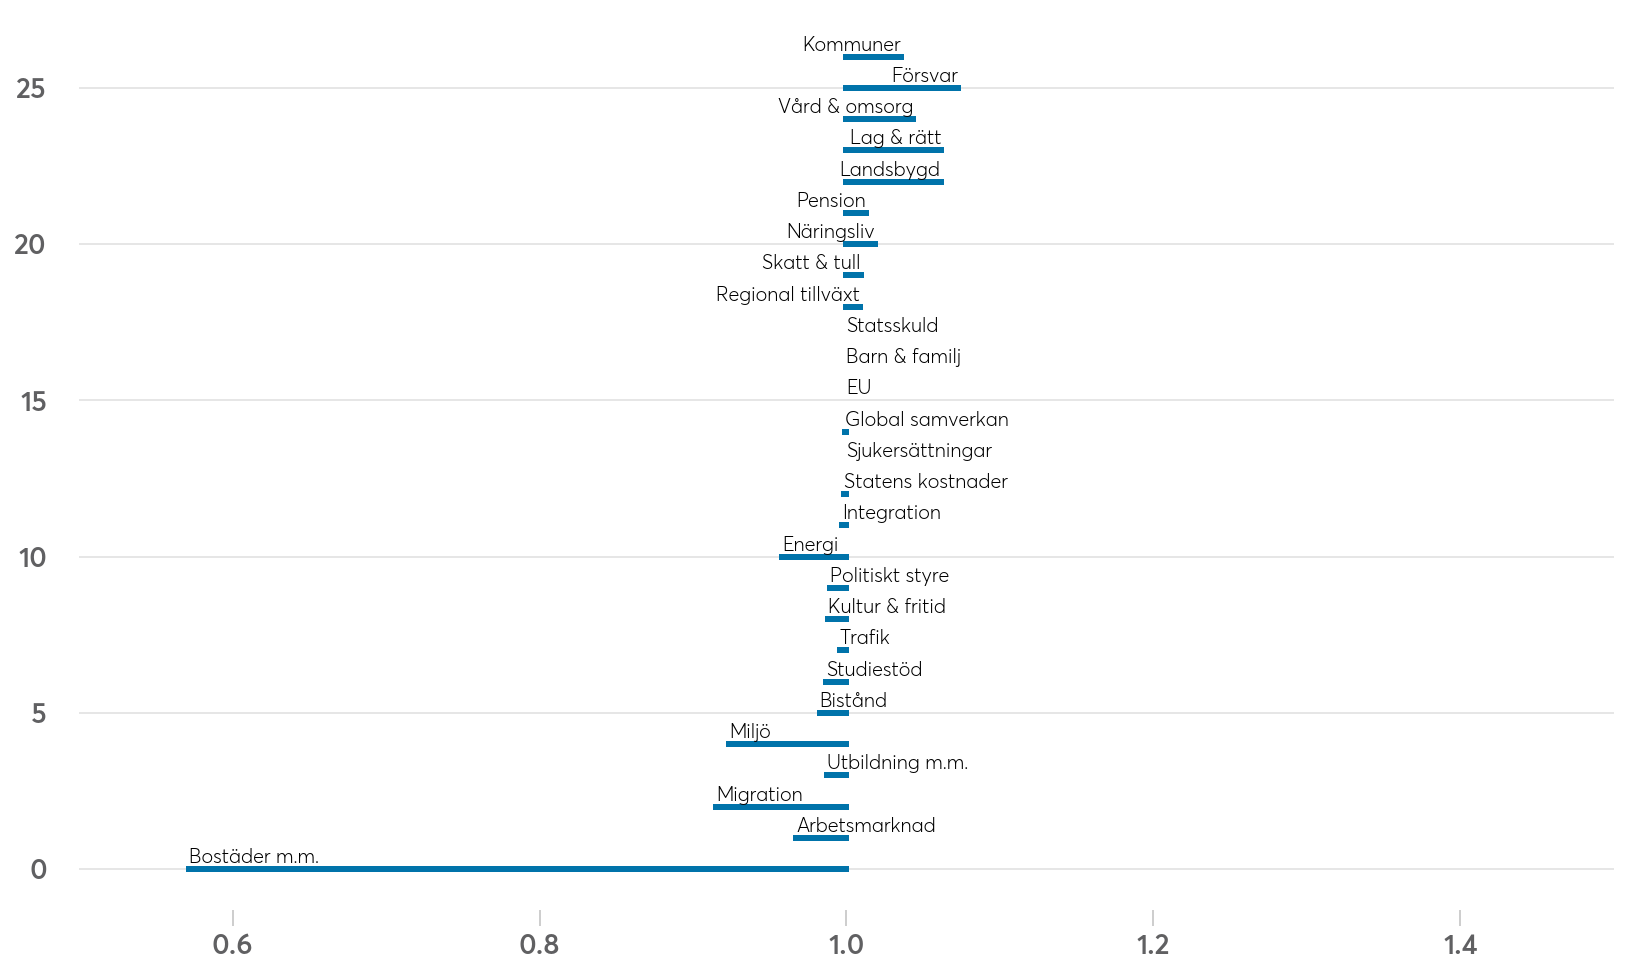

In [16]:
fig, ax = ds_plot()
colors = ['#f85242', '#0073aa', '#57d298']

for i, row in df.sort_values('diff').reset_index(drop=True).iterrows():
    ax.set_xlim(0.5, 1.5)
    change = row.budget_gov_new / row.budget_gov_old
    ax.plot([row.budget_gov_old / row.budget_gov_old, change],
            [i, i], color=colors[1], lw=3)
    ha = 'right' if change > 1 else 'left'
    ax.text(change, i + 0.2, row.short_name, ha=ha, weight=200, size=10)

plt.tight_layout(h_pad=3, w_pad=1)
fig.set_facecolor('#ffffff');

### Line charts with all budgets

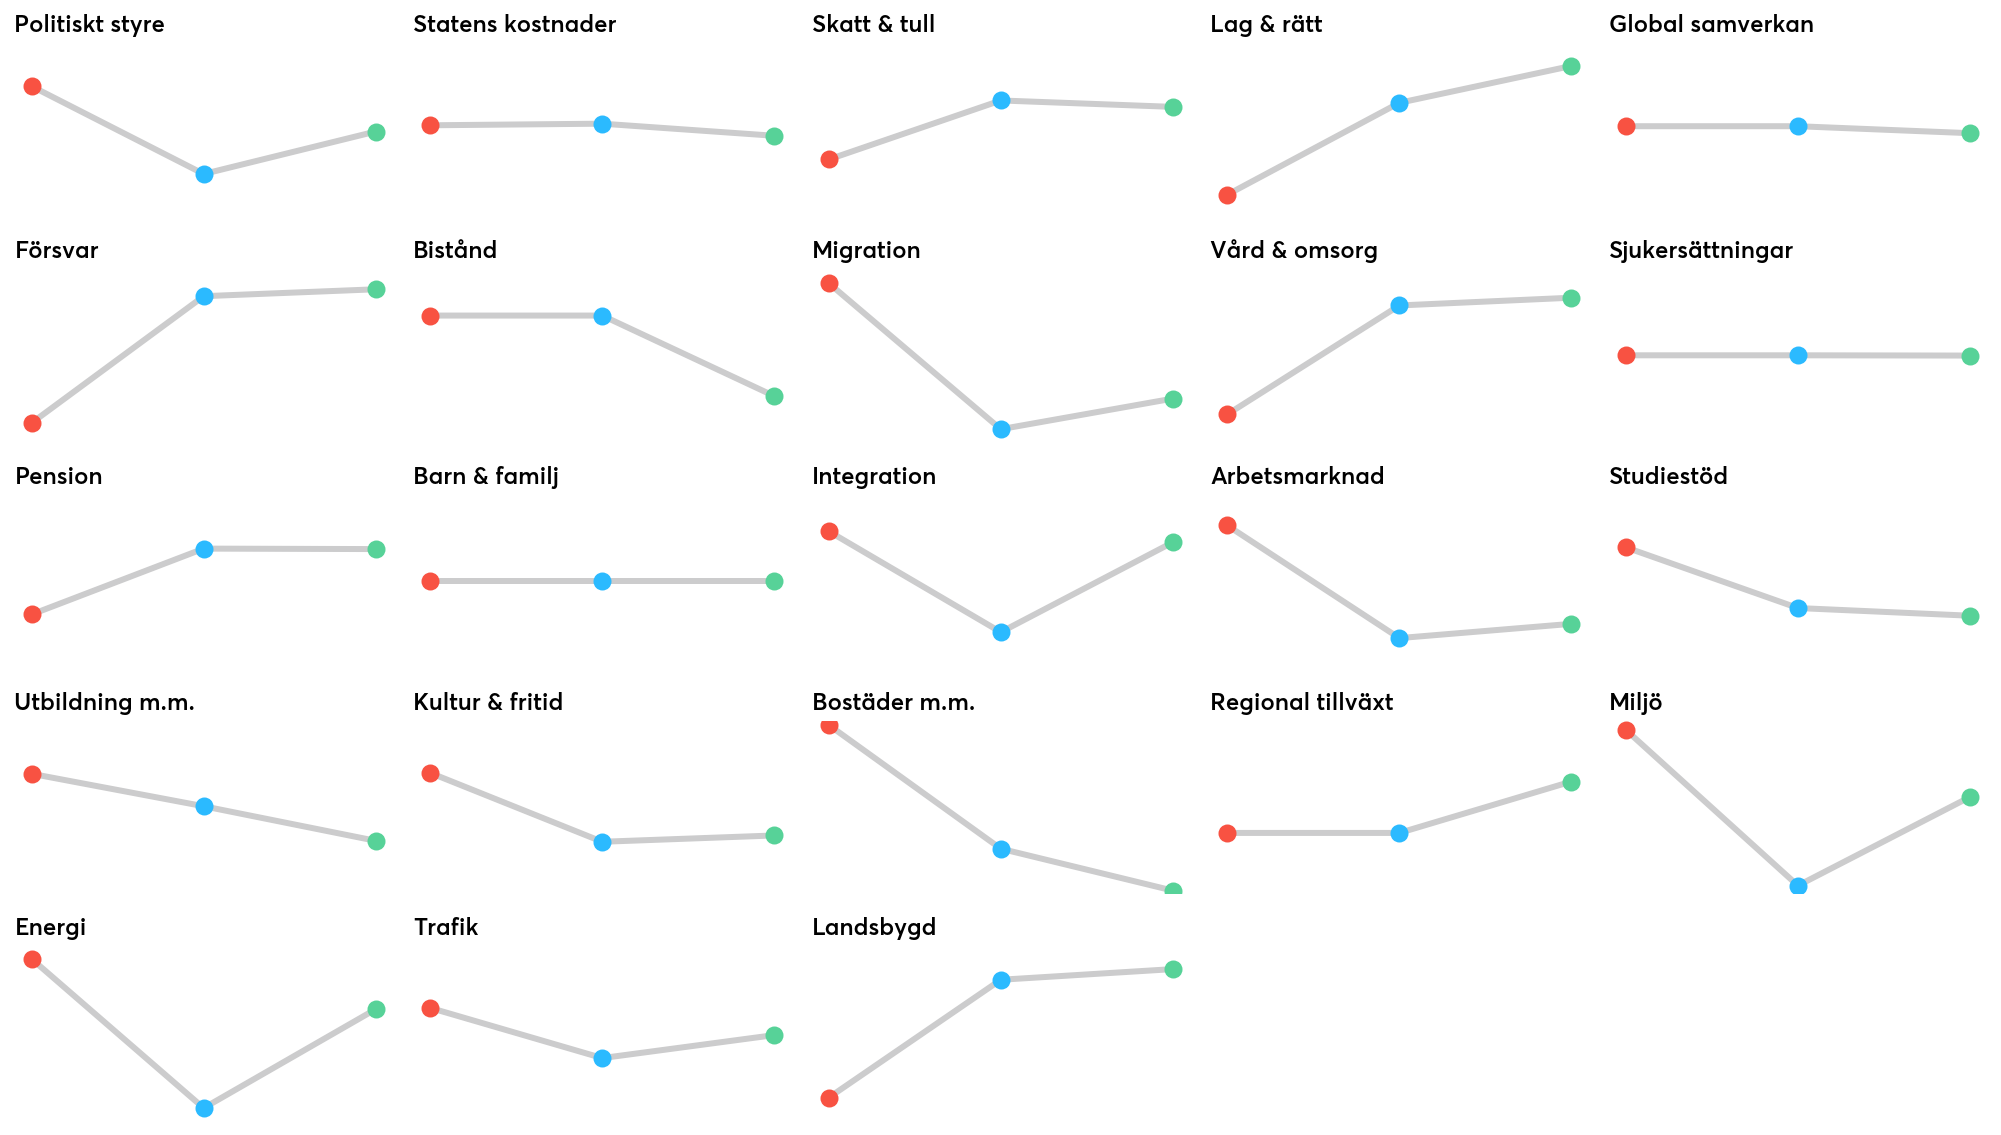

In [17]:
fig, axes = plt.subplots(5, 5, figsize=(14, 8), sharey=False, sharex=True)

for (i, row), ax in zip(df.iterrows(), axes.flat):
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Regeringen', 'M+Kd', 'Ändring'], size=10)
    ax.plot([row.budget_gov_old, row.budget_m_kd, row.budget_gov_new], lw=3, color='#cccccd')
    ax.plot(row.budget_gov_old, 'o', color='#f85242', ms=8)
    ax.plot([1], [row.budget_m_kd], 'o', color='#2bbaff', ms=8)
    ax.plot([2], row.budget_gov_new, 'o', color='#57d298', ms=8)
    
    nums = row[['budget_m_kd', 'budget_gov_new', 'budget_gov_old']]
    ax.set_ylim(nums.min() * 0.99, nums.max() * 1.01)
    
    ax.set_title(row.short_name, size=12, weight=500, loc='left')
    ax.set_yticklabels([])
    ax.get_xaxis().set_visible(False)
    ax.grid(False)


axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)

plt.tight_layout(h_pad=1, w_pad=1)
fig.set_facecolor('#ffffff');

### Combined bar charts

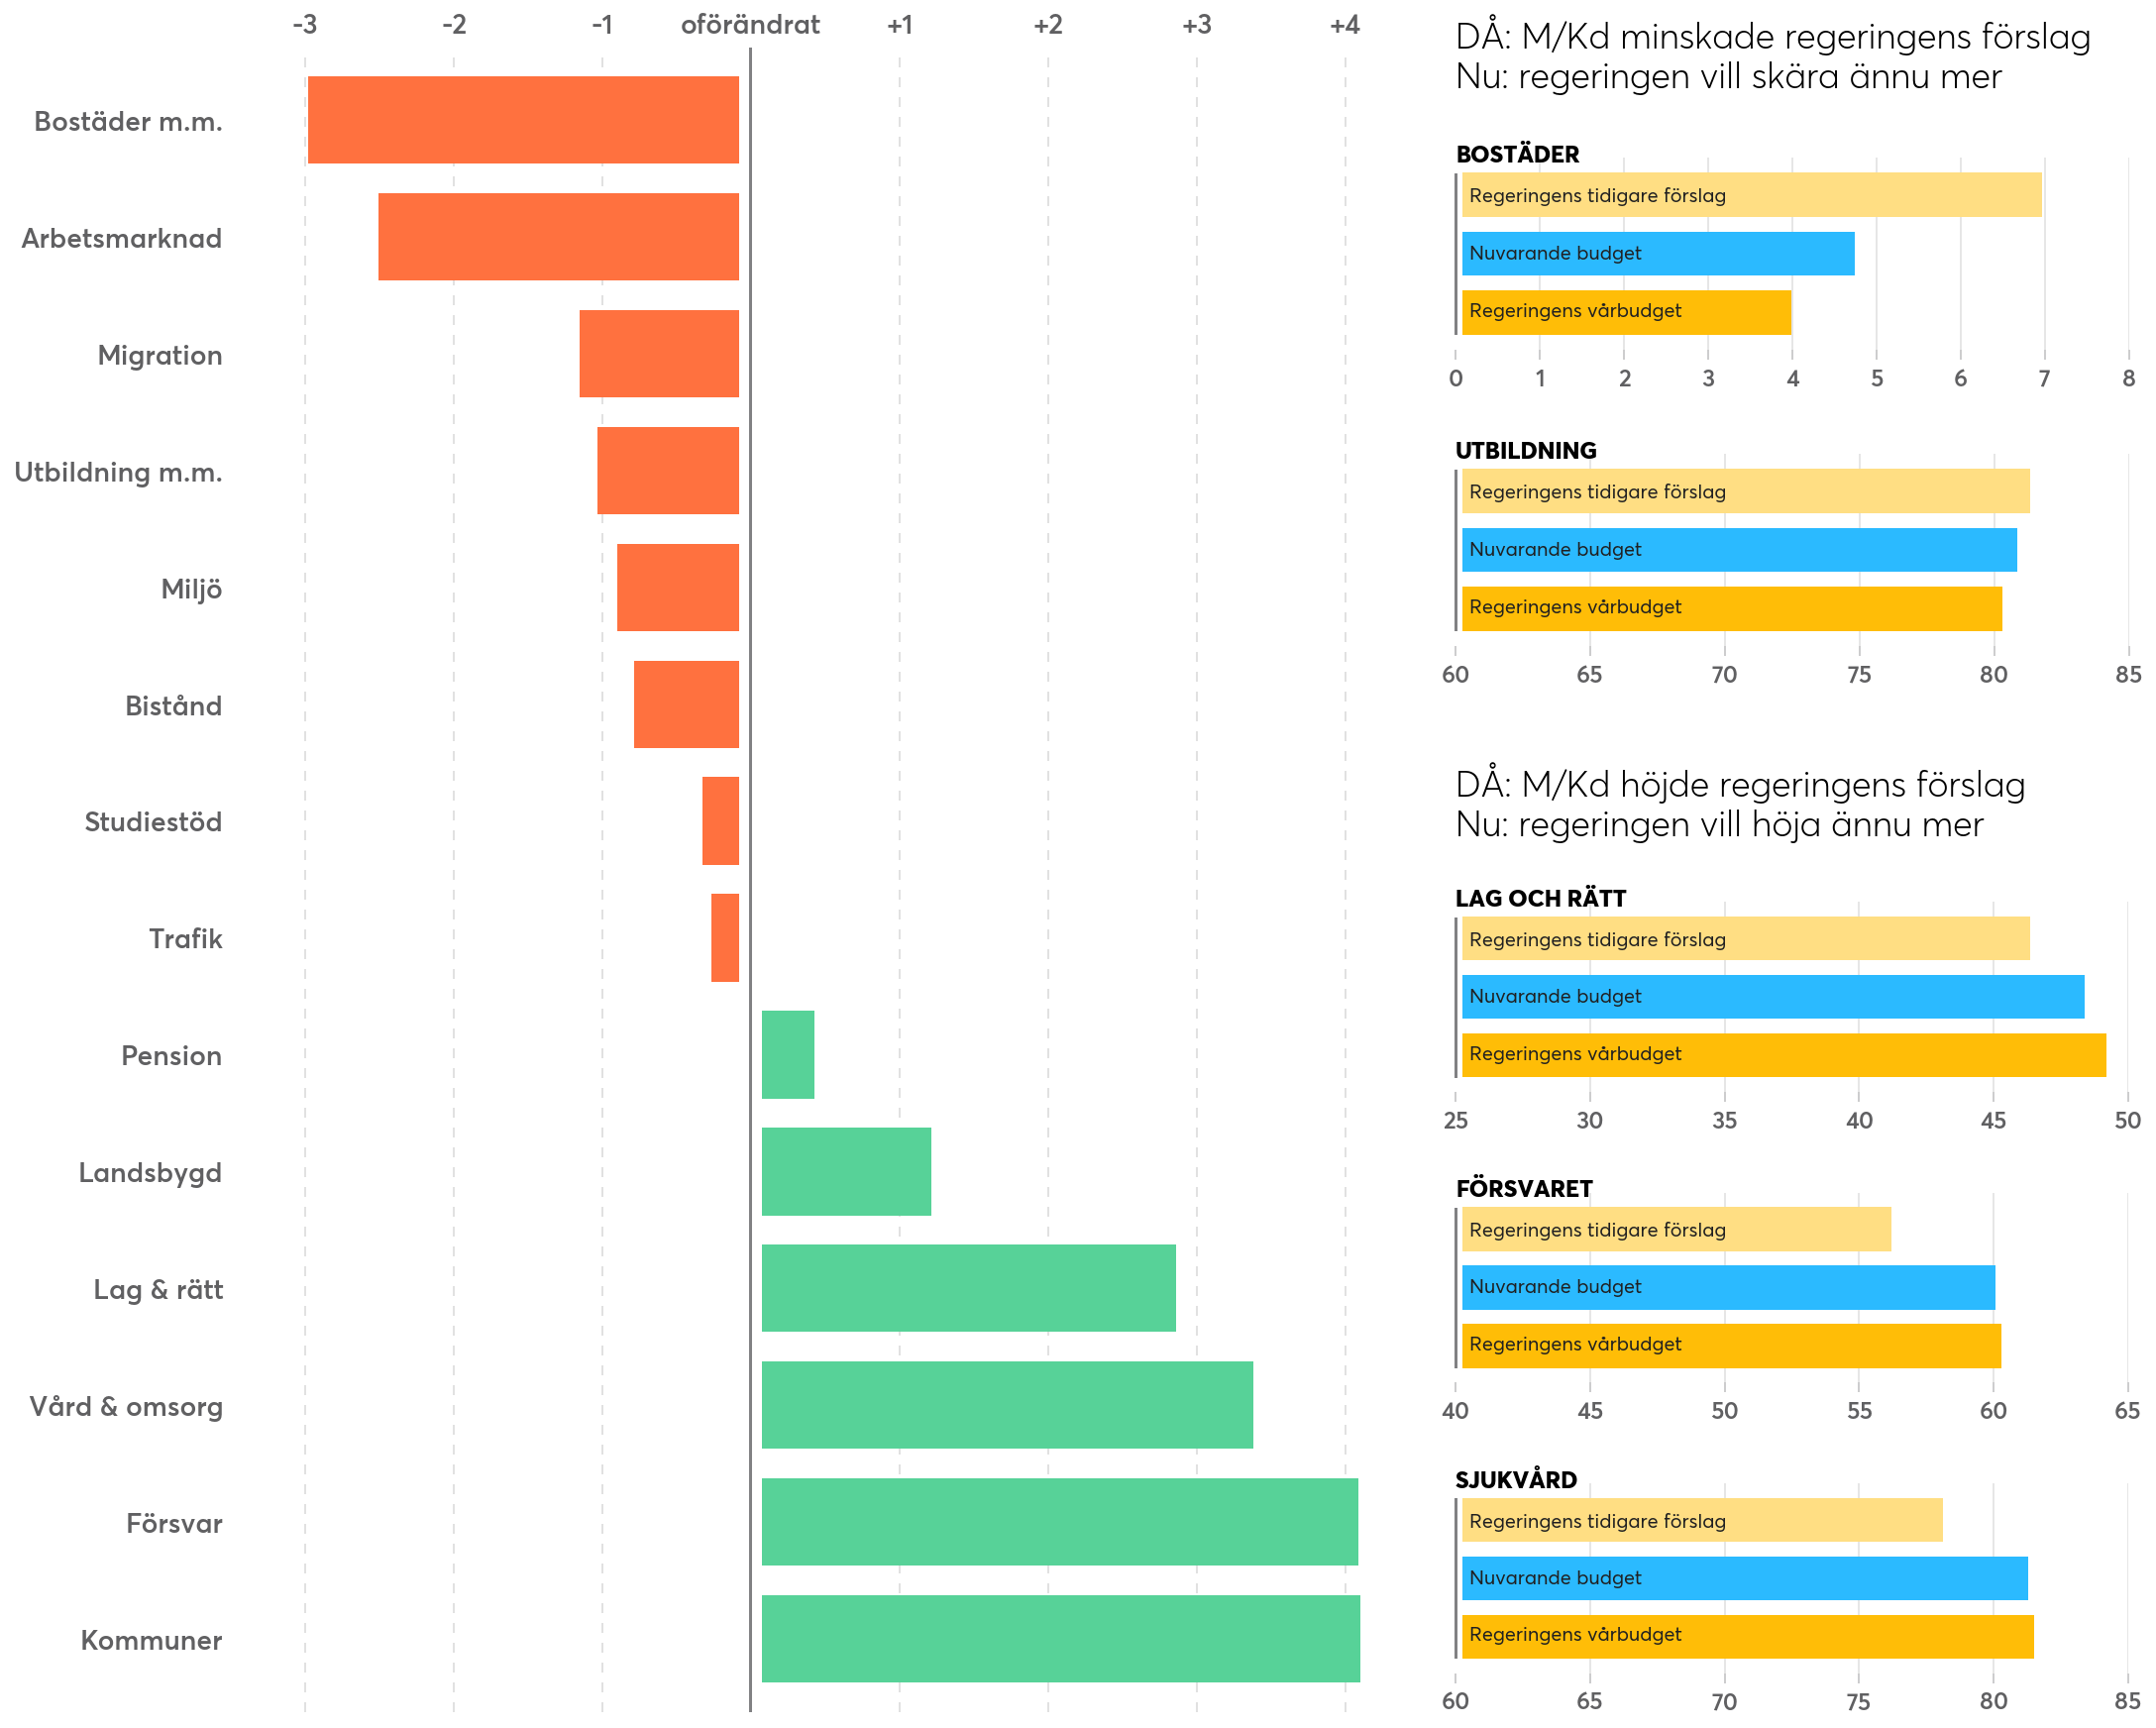

In [18]:
# Setup figure and grid
fig = plt.figure(figsize=(15, 12), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.04167, h_pad=0.04167, wspace=0.02, hspace=0.2)
gs = gridspec.GridSpec(5, 3, figure=fig)

# Setup data
data = df.sort_values('diff', ascending=False).set_index('short_name')

# Change values to billion kronor
data.budget_m_kd = data.budget_m_kd / 1e9
data.budget_gov_new = data.budget_gov_new / 1e9
data.budget_gov_old = data.budget_gov_old / 1e9
data['diff'] = data['diff'] / 1e9

# Drop expenditures that haven't changed much
data = data[data['diff'].abs() > 0.2]

# Add some checks so to make sure we haven't
# messed anything up in another cell...
assert int(data.loc['Kommuner'].budget_m_kd) == 119
assert int(data.loc['Försvar'].budget_m_kd) == 60
assert int(data.loc['Migration'].budget_gov_new) == 12
assert int(data.loc['Lag & rätt'].budget_gov_old) == 46

# Reusables
bar_label_font = dict(size=10, weight='regular', va='center', color='#202021')
expenditure_font = dict(size=12, weight='bold', loc='left')
summary_font = dict(size=18, weight='light', va='top')
bar_colors = ['#ffbd07', '#2bbaff', '#ffde83']
cols = ['budget_gov_old', 'budget_m_kd', 'budget_gov_new']

def plot_bars(ax, label, xlim, title):
    """Plot smaller bar graphs with all budgets."""
    d = data.loc[label][reversed(cols)]
    d.plot.barh(color=bar_colors, ax=ax, width=0.75)
    ax.text(0.02, .8, 'Regeringens tidigare förslag', **bar_label_font, transform=ax.transAxes)
    ax.text(0.02, .5, 'Nuvarande budget', **bar_label_font, transform=ax.transAxes)
    ax.text(0.02, .2, 'Regeringens vårbudget', **bar_label_font, transform=ax.transAxes)
    ax.get_yaxis().set_ticks([])
    ax.set_xlim(xlim[0], xlim[1])
    ax.xaxis.set_tick_params(color='#c2c2c3', length=5, labelsize=12)
    ax.set_title(title, **expenditure_font, pad=-2)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_bounds(-0.35, 2.35)
    ax.spines['left'].set_color('#818183')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['left'].set_position(('outward', 0))
    ax.axvline(xlim[0], color='#ffffff', lw=7)
    ax.set_axisbelow(True)
    return ax

# Main plot
ax = plt.subplot(gs[:, 0:2])
color = data['diff'].apply(lambda x: '#57d298' if x > 0 else '#ff713f')
data.plot.barh(y='diff', ax=ax, color=color, width=0.75)
ax.xaxis.set_label('')
ax.xaxis.tick_top()
plt.ylabel('')
ax.grid(False)
ax.grid(True, axis='x', linestyle='--', dashes=(5, 5), lw=1)
ax.xaxis.set_tick_params(length=0)
ax.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4])
ax.set_xticklabels(['-3', '-2', '-1', 'oförändrat', '+1', '+2', '+3', '+4'])
ax.set_axisbelow(True)
ax.axvline(0, color='#818183', lw=2)
ax.axvline(-0.05, color='#ffffff', lw=5)
ax.axvline(0.04, color='#ffffff', lw=5)
ax.legend().remove()

####################################

# Upper side plots
gs_less = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs[0:2, 2])

# Headline 1
ax1 = plt.subplot(gs_less[0, 0])
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.text(0, 1, 'DÅ: M/Kd minskade regeringens förslag\nNu: regeringen vill skära ännu mer', **summary_font)

# Bostäder
ax2 = plt.subplot(gs_less[1:5, 0])
plot_bars(ax2, 'Bostäder m.m.', [0, 8], 'BOSTÄDER')

# Utbildning
ax3 = plt.subplot(gs_less[5:, 0])
plot_bars(ax3, 'Utbildning m.m.', [60, 85], 'UTBILDNING')

####################################

# Lower side plots
gs_more = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs[2:, 2])

# Headline 2
axm1 = plt.subplot(gs_more[0, 0])
axm1.axes.get_xaxis().set_visible(False)
axm1.axes.get_yaxis().set_visible(False)
axm1.text(0, 0, 'DÅ: M/Kd höjde regeringens förslag\nNu: regeringen vill höja ännu mer', **summary_font)

# Polisen
axm2 = plt.subplot(gs_more[1:4, 0])
plot_bars(axm2, 'Lag & rätt', [25, 50], 'LAG OCH RÄTT')

# Försvaret
axm3 = plt.subplot(gs_more[4:7, 0])
plot_bars(axm3, 'Försvar', [40, 65], 'FÖRSVARET')

# Sjukvård
axm4 = plt.subplot(gs_more[7:, 0])
plot_bars(axm4, 'Vård & omsorg', [60, 85], 'SJUKVÅRD');